# SVM

dataset: https://www.kaggle.com/datasets/ozguraslank/brain-stroke-ct-dataset?resource=download

Reference used to read dataset:
* https://www.kaggle.com/code/ozguraslank/reading-brain-stroke-ct-dataset


Here we use 32x32 images


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.svm import LinearSVC #C-support vector Clasification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import os
import time
from PIL import Image
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


## Data processing 

In [2]:
path = 'Brain_Stroke_CT_Dataset/'

#Path de las imágenes
normal_path = path + "Normal" + "/" + "PNG" #Debe ser así pa q funcione tipo expresion regular
ischemia_path = path + "Ischemia" + "/" + "PNG"
bleeding_path = path + "Bleeding" + "/" + "PNG"

#Path de las máscaras
ischemia_mask_path = path + "Ischemia" + "/" + "OVERLAY"
bleeding_mask_path = path + "Bleeding" + "/" + "OVERLAY"

#Obtenemos todas las imágenes
normal_folder = os.listdir(normal_path)
ischemia_folder = os.listdir(ischemia_path)
bleeding_folder = os.listdir(bleeding_path)

#Mostramos cantidad de datos por clase para ver desbalance
size_normal = len(normal_folder)
size_ischemia = len(ischemia_folder)
size_bleeding = len(bleeding_folder)
print("Normal:", size_normal)
print("Ischemia:", size_ischemia)
print("Bleeding:", size_bleeding)


Normal: 4427
Ischemia: 1130
Bleeding: 1093


In [3]:
def process_image(file_path, dim, scale):
    img = Image.open(file_path)
    img = img.convert(scale) #Escala de grises o RGB
    img = img.resize(dim) #Reescalamos
    img = np.array(img)
    return img.flatten()

In [4]:
#Almacenamos todas las imágenes
data = []
dim = (512,512) #resize

folders = [normal_folder, ischemia_folder, bleeding_folder]
paths = [normal_path, ischemia_path, bleeding_path]

for i in range(len(folders)):

    #Recorremos todos los archivos de la carpeta y path i 
    for file_name in folders[i]:
        img = process_image(paths[i] + "/" + file_name, dim, 'L') #L = escala de grises
        data.append(img)


In [5]:
#Verificamos dimensión de los datos
data = np.array(data)
data.shape

(6650, 262144)

In [6]:
#Creamos el vector de labels
y = np.zeros(6650)
y[:size_normal] = 0 #Normal label [0:4427]
y[size_normal:size_normal+size_ischemia] = 1 #Ishcemia label [4427: 5557]
y[size_normal+size_ischemia:] = 2   #bleeding label [5557:]
y.shape

(6650,)

In [7]:
data.shape

(6650, 262144)

In [8]:

X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=42)
(X_train.shape, X_test.shape)


((4655, 262144), (1995, 262144))

### Image examples

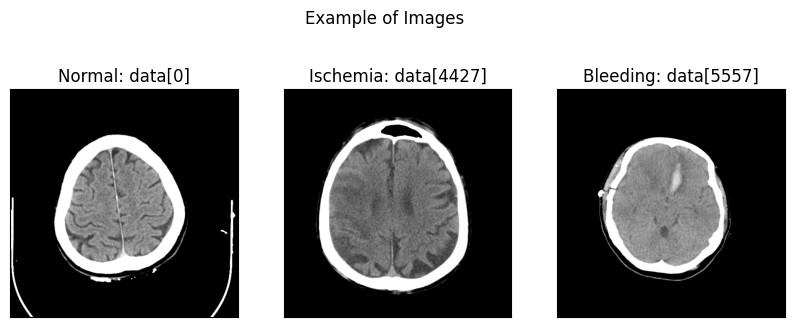

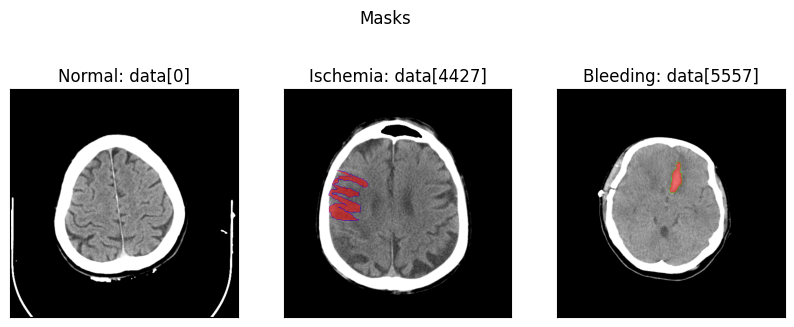

In [9]:
#Mostrmoas una imágen de ejemplo (para ver si el vector y está bien)
f, axes = plt.subplots(1, 3)
f.set_figheight(4)
f.set_figwidth(10)
f.suptitle("Example of Images")

axes[0].set_title("Normal: data[0]")
axes[0].imshow(data[0].reshape(dim), cmap="gray")
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_title("Ischemia: data[4427]")
axes[1].imshow(data[4427].reshape(dim), cmap="gray")
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_title("Bleeding: data[5557]")
axes[2].imshow(data[5557].reshape(dim), cmap="gray")
axes[2].set_xticks([])
axes[2].set_yticks([])
plt.show()


#We will also show the masks of the above pictures (manual)

data0_path =    normal_path    + "/10000.png"
data4427_path = ischemia_mask_path  + "/10003.png"
data5557_path = bleeding_mask_path  + "/10002.png"

mask_data0 = process_image(data0_path, dim, "RGB")
mask_data4427 = process_image(data4427_path, dim, "RGB")
mask_data5557 = process_image(data5557_path, dim, "RGB")


f, axes = plt.subplots(1, 3)
f.set_figheight(4)
f.set_figwidth(10)
f.suptitle("Masks")

axes[0].set_title("Normal: data[0]")
axes[0].imshow(mask_data0.reshape((dim[0], dim[1], 3)))
axes[0].set_xticks([])
axes[0].set_yticks([])

axes[1].set_title("Ischemia: data[4427]")
axes[1].imshow(mask_data4427.reshape((dim[0], dim[1], 3)))
axes[1].set_xticks([])
axes[1].set_yticks([])

axes[2].set_title("Bleeding: data[5557]")
axes[2].imshow(mask_data5557.reshape((dim[0], dim[1], 3)))
axes[2].set_xticks([])
axes[2].set_yticks([])
plt.show()


## SVM model

references: 
* https://www.geeksforgeeks.org/multi-class-classification-using-support-vector-machines-svm/
* https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html

### Using one vs rest strategy

In [ ]:
#Inicializamos el modelo SVM
svm_ovo = LinearSVC(random_state=42, max_iter=10000)

start_time = time.time()
svm_ovo.fit(X_train, y_train)
end_time = time.time()

print("Training time (min):", (end_time-start_time)/60)


Training time: 3515.9866120815277


In [12]:
y_pred = svm_ovo.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")

# Detailed report: precision, recall, F1
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["Normal", "Ischemia", "Bleeding"]))

Accuracy: 0.8627

Classification Report:
              precision    recall  f1-score   support

      Normal       0.90      0.92      0.91      1347
    Ischemia       0.75      0.73      0.74       330
    Bleeding       0.81      0.75      0.78       318

    accuracy                           0.86      1995
   macro avg       0.82      0.80      0.81      1995
weighted avg       0.86      0.86      0.86      1995

